# Download of the Dataset

In [69]:
# Import libraries
import os
import numpy as np
import pandas as pd

In [70]:
cwd = '/content'
zip_url = 'https://archive.ics.uci.edu/static/public/240/human+activity+recognition+using+smartphones.zip'
zip_path = '/content/human+activity+recognition+using+smartphones.zip'
data_set_name = 'UCI HAR Dataset'
data_set_zip_path = os.path.join(cwd, f'{data_set_name}.zip')
data_set_path = os.path.join(cwd,data_set_name)
# Downloads data if neccesary
if not os.path.exists(data_set_path):
  try:
    if not os.path.exists(zip_path):
      # Download the .zip file
      !wget -O {zip_path} {zip_url}

    if not os.path.exists(os.path.join(cwd,f'{data_set_name}.zip')):
      # Unzip the file
      !unzip {zip_path} "{data_set_name}.zip" -d {cwd}

    # Unzip the second zip
    !unzip "{data_set_zip_path}" "{data_set_name}/*" -d "{cwd}"
  except Exception as e:
    print(f"An error occured {str(e)}")
  else:
    # Deletes remaining zip archives
    !rm {zip_path} "{data_set_zip_path}"

# Data Exploration

In [71]:
# Paths to the data
train_time_series_path = os.path.join(data_set_path, 'train', 'Inertial Signals')
test_time_series_path = os.path.join(data_set_path, 'test', 'Inertial Signals')

# Paths to the time series
train_labels_path = os.path.join(data_set_path, 'train', 'y_train.txt')
test_labels_path = os.path.join(data_set_path, 'test', 'y_test.txt')

time_series_test = pd.read_csv(os.path.join(train_time_series_path,'body_acc_x_train.txt'), sep='\s+')
time_series_test.shape # Testing the shape of the dataset

(7351, 128)

In [72]:
# Number of samples, time steps, and features
train_n_samples, test_n_samples, n_time_steps, n_features, n_classes = 7352, 2947, 128, 9, 6

# Name of the features
feature_names = [
  'body_acc_x',
  'body_acc_y',
  'body_acc_z',
  'body_gyro_x',
  'body_gyro_y',
  'body_gyro_z',
  'total_acc_x',
  'total_acc_y',
  'total_acc_z'
]

## Processing Data

Los datos se ordenaron en arreglos tridimiensionales de la forma: (muestras, pasos de tiempo, caracteristicas) por lo que se tienen muestras correspondientes a series temporales de 128 elementos/pasos de tiempo y con valores de 9 caracteristicas en cada uno de ellos. Además, se entregan arreglos con valores "one-hot encoded" correspondientes a las clases que corresponden a cada una de las muestras.

In [73]:
# Function that returns the required Dataframes
def format_data(n_samples: int, n_time_steps: int, n_features: int, n_classes: int,  feature_names: list[str], labels_path: str, time_series_path: str, set_type: str = 'train') -> tuple[np.ndarray, np.ndarray] :
  import numpy as np
  import pandas as pd
  import tensorflow.keras.utils as utils
  import os
  # Initialize an empty array for the features
  features = np.zeros((n_samples, n_time_steps, n_features))
  # Loops thorugh the files of the features
  for index, feature in enumerate(feature_names):
    file_path = os.path.join(time_series_path, f'{feature}_{set_type}.txt')
    feature_matrix = pd.read_csv(file_path, sep='\s+', header=None).values
    features[:, :, index] = feature_matrix

  # Loads the labels
  labels = pd.read_csv(labels_path, sep='\s+', header=None).values.flatten() - 1
  labels = utils.to_categorical(labels, num_classes=n_classes)

  return features, labels

train_data, train_labels = format_data(
    n_samples=train_n_samples,
    n_time_steps=n_time_steps,
    n_features=n_features,
    n_classes=n_classes,
    feature_names=feature_names,
    labels_path=train_labels_path,
    time_series_path=train_time_series_path
)

test_data, test_labels = format_data(
    n_samples=test_n_samples,
    n_time_steps=n_time_steps,
    n_features=n_features,
    n_classes=n_classes,
    feature_names=feature_names,
    labels_path=test_labels_path,
    time_series_path=test_time_series_path,
    set_type='test'
)

# Compare predicted Classes to the original class labels (which need to be in 1 to 6 format)
original_classes = np.argmax(test_labels, axis=1) + 1

In [74]:
# Loads class names
labels = pd.read_csv(os.path.join(data_set_path,'activity_labels.txt'), sep='\s+', header=None)[1].values
labels

array(['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING',
       'STANDING', 'LAYING'], dtype=object)

## Defining Metrics

In [75]:
def print_metrics(original_classes: np.ndarray[int], predictions: np.ndarray[np.float32], labels: np.ndarray[str]) -> None:
  import numpy as np
  %matplotlib inline
  import matplotlib.pyplot as plt
  import seaborn as sns
  import tensorflow as tf
  from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
  from tensorflow.keras.losses import categorical_crossentropy
  from tensorflow.keras.utils import to_categorical
  # Class with highest probability
  predicted_classes = np.argmax(predictions, axis=1)
  predicted_classes += 1

  # Accuracy
  accuracy = accuracy_score(original_classes, predicted_classes)
  print(f'Accuracy: {accuracy:.2f}')

  # Confusion matrix
  conf_matrix = confusion_matrix(original_classes, predicted_classes)
  cm_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

  plt.figure(figsize=(10, 8))
  ax = sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='RdPu',
              xticklabels=labels, yticklabels=labels, annot_kws={"size": 16})
  # Set font size for the colorbar label
  cbar = ax.collections[0].colorbar
  # Set font size for the colorbar tick labels
  cbar.ax.tick_params(labelsize=12)
  ax.tick_params(labelsize=12)

  # Add labels to the plot
  plt.title('Normalized Confusion Matrix', fontsize=20)
  plt.ylabel('True label', fontsize=16)
  plt.xlabel('Predicted label', fontsize=16)
  plt.show()

  # Precision, recall, and F1 score for each class
  precision = [f'{class_precision:.2f}' for class_precision in precision_score(original_classes, predicted_classes, average=None)]
  recall = [f'{class_recall:.2f}' for class_recall in recall_score(original_classes, predicted_classes, average=None)]
  f1 = [f'{class_f1:.2f}' for class_f1 in f1_score(original_classes, predicted_classes, average=None)]

  print(f'Precision per class: {", ".join(precision)}')
  print(f'Recall per class: {", ".join(recall)}')
  print(f'F1 Score per class: {", ".join(f1)}')

  # Single precision, recall and f1 score
  precision_macro = precision_score(original_classes, predicted_classes, average='macro')
  recall_macro = recall_score(original_classes, predicted_classes, average='macro')
  f1_macro = f1_score(original_classes, predicted_classes, average='macro')

  print(f'Macro Precision: {precision_macro:.2f}')
  print(f'Macro Recall: {recall_macro:.2f}')
  print(f'Macro F1 Score: {f1_macro:.2f}')

  # Categorical cross-entrhopy loss
  categorical_original_classes = to_categorical(original_classes - 1, num_classes=6)
  loss = categorical_crossentropy(tf.convert_to_tensor(categorical_original_classes, dtype=tf.float32),
                                tf.convert_to_tensor(predictions, dtype=tf.float32))
  mean_loss = tf.reduce_mean(loss).numpy()
  print(f'Mean cross-entropy loss: {mean_loss:.2f}')


In [76]:
def plot_roc_curve(test_labels: np.ndarray, predicted_labels: np.ndarray, n_classes: int, labels: list[str]) -> None:
  import numpy as np
  %matplotlib inline
  import matplotlib.pyplot as plt
  from sklearn.metrics import roc_curve, auc
  from sklearn.preprocessing import label_binarize

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], predicted_labels[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  '''
  Plotting all ROC curves
  '''

  # Initialize the combined plot
  with plt.ioff():
    fig_combined, ax_combined = plt.subplots(figsize=(8, 6))

    # Loop through classes to plot individual and accumulate for the combined plot
    for i in range(n_classes):
      # Individual ROC plot for each class
      fig, ax = plt.subplots()  # This creates a new figure and axes for each individual ROC curve
      ax.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:0.2f})')
      ax.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
      ax.set_xlim([0.0, 1.0])
      ax.set_ylim([0.0, 1.05])
      ax.set_xlabel('False Positive Rate', fontsize=16)
      ax.set_ylabel('True Positive Rate', fontsize=16)
      ax.set_title(f'Receiver Operating Characteristic for class {labels[i]}', fontsize=20)
      ax.legend(loc="lower right", fontsize=12)
      ax.tick_params(axis='both', which='major', labelsize=16)

      # Add to the combined ROC plot
      ax_combined.plot(fpr[i], tpr[i], label=f'Class {labels[i]} ROC curve (area = {roc_auc[i]:0.2f})')

    # Finalize the combined ROC plot
    ax_combined.plot([0, 1], [0, 1], 'k--', label='Random chance (area = 0.50)')
    ax_combined.tick_params(axis='both', which='major', labelsize=16)
    ax_combined.set_xlim([0.0, 1.0])
    ax_combined.set_ylim([0.0, 1.05])
    ax_combined.set_xlabel('False Positive Rate', fontsize=16)
    ax_combined.set_ylabel('True Positive Rate', fontsize=16)
    ax_combined.set_title('Receiver Operating Characteristic (ROC) - All Classes', fontsize=20)
    ax_combined.legend(loc="lower right", fontsize=12)
    plt.show()

# CNN-GRU

## Creating Model

In [77]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Dropout, Flatten

# Define the CNN-GRU model
cnn_gru_model = Sequential([
    # Convolutional layer
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_time_steps, n_features)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    # GRU layer
    GRU(64, return_sequences=True),
    Dropout(0.5),
    GRU(64, return_sequences=False),
    Dropout(0.5),
    # Dense layer for classification
    Dense(64, activation='relu'),
    Dense(n_classes, activation='softmax')
])

# Compile the model
cnn_gru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model's architecture
cnn_gru_model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_13 (Conv1D)          (None, 126, 64)           1792      
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 63, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_14 (Conv1D)          (None, 61, 128)           24704     
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 30, 128)          0         
 g1D)                                                            
                                                                 
 gru_6 (GRU)                 (None, 30, 64)            37248     
                                                                 
 dropout_9 (Dropout)         (None, 30, 64)           

## Testing Model

In [78]:
# Train the model
history = cnn_gru_model.fit(train_data, train_labels, epochs=10, batch_size=32, validation_split=0.2)

# Predictions with test data
cnn_gru_predictions = cnn_gru_model.predict(test_data)

Epoch 1/10
184/184 [==============================] - 21s 87ms/step - loss: 0.7092 - accuracy: 0.7106 - val_loss: 0.4332 - val_accuracy: 0.8613
Epoch 2/10
184/184 [==============================] - 15s 81ms/step - loss: 0.2064 - accuracy: 0.9305 - val_loss: 0.3727 - val_accuracy: 0.9082
Epoch 3/10
184/184 [==============================] - 14s 77ms/step - loss: 0.1546 - accuracy: 0.9439 - val_loss: 0.4801 - val_accuracy: 0.8967
Epoch 4/10
184/184 [==============================] - 12s 65ms/step - loss: 0.1248 - accuracy: 0.9519 - val_loss: 0.4618 - val_accuracy: 0.9014
Epoch 5/10
184/184 [==============================] - 14s 75ms/step - loss: 0.1269 - accuracy: 0.9510 - val_loss: 0.4741 - val_accuracy: 0.9069
Epoch 6/10
184/184 [==============================] - 14s 77ms/step - loss: 0.1103 - accuracy: 0.9541 - val_loss: 0.5368 - val_accuracy: 0.9123
Epoch 7/10
184/184 [==============================] - 14s 78ms/step - loss: 0.1020 - accuracy: 0.9534 - val_loss: 0.5516 - val_accuracy:

Accuracy: 0.90


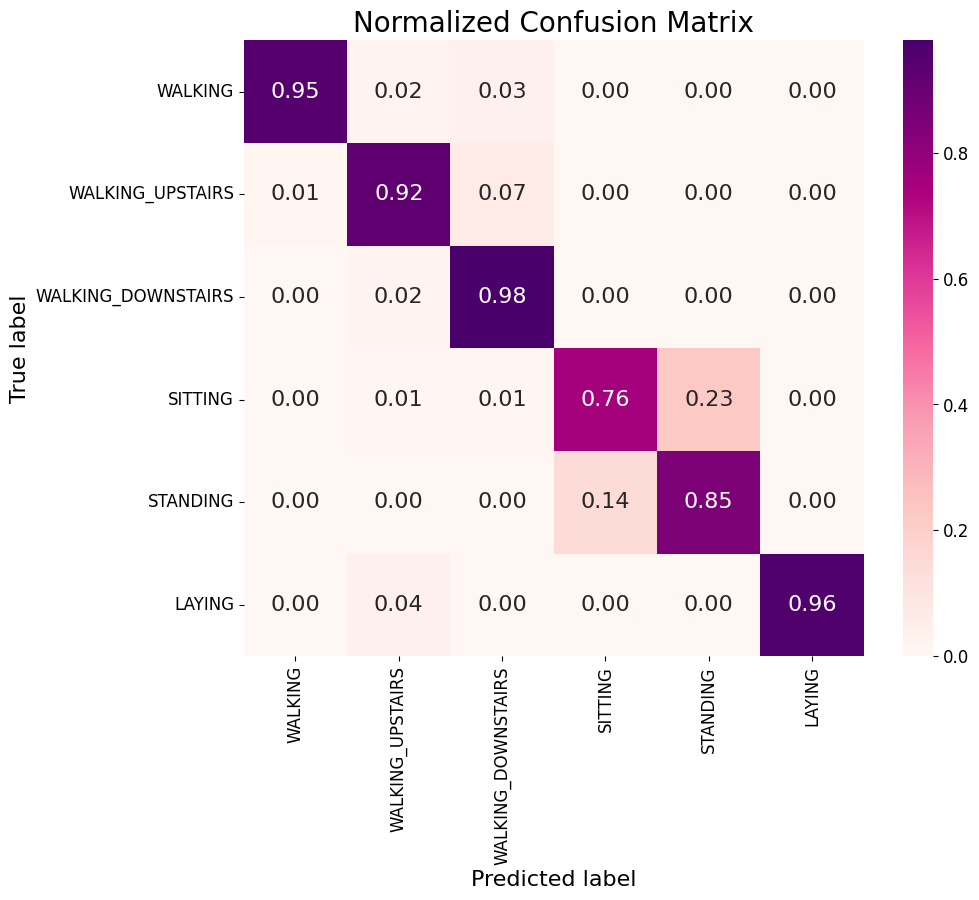

Precision per class: 0.99, 0.91, 0.88, 0.83, 0.80, 1.00
Recall per class: 0.95, 0.92, 0.98, 0.76, 0.85, 0.96
F1 Score per class: 0.97, 0.91, 0.93, 0.79, 0.83, 0.98
Macro Precision: 0.90
Macro Recall: 0.90
Macro F1 Score: 0.90
Mean cross-entropy loss: 0.40


In [79]:
print_metrics(original_classes, cnn_gru_predictions, labels)

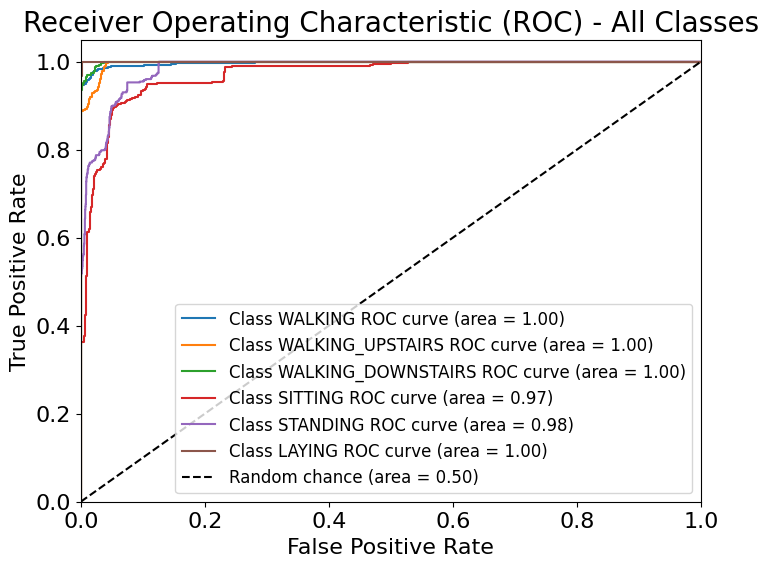

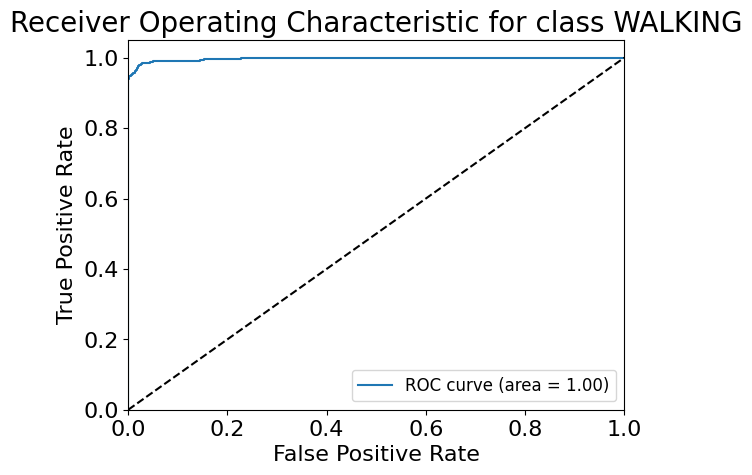

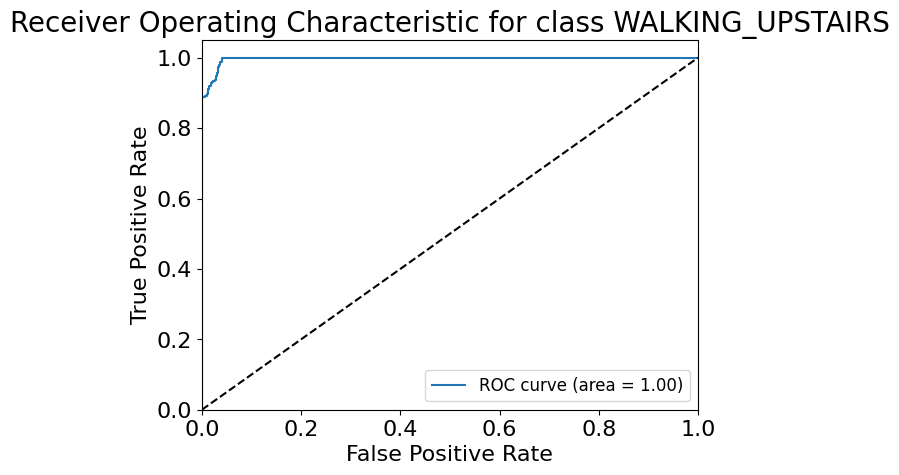

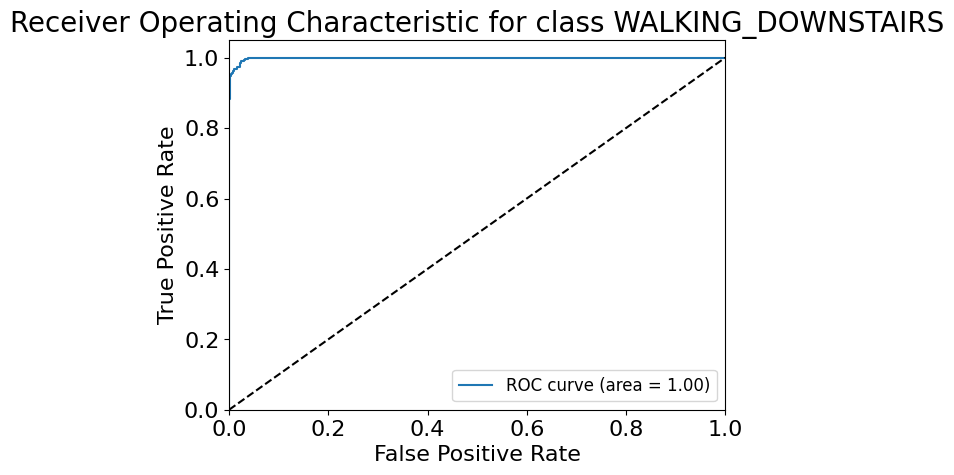

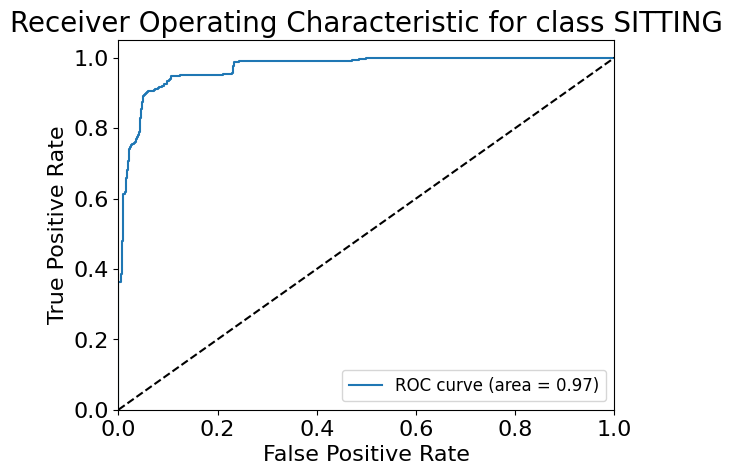

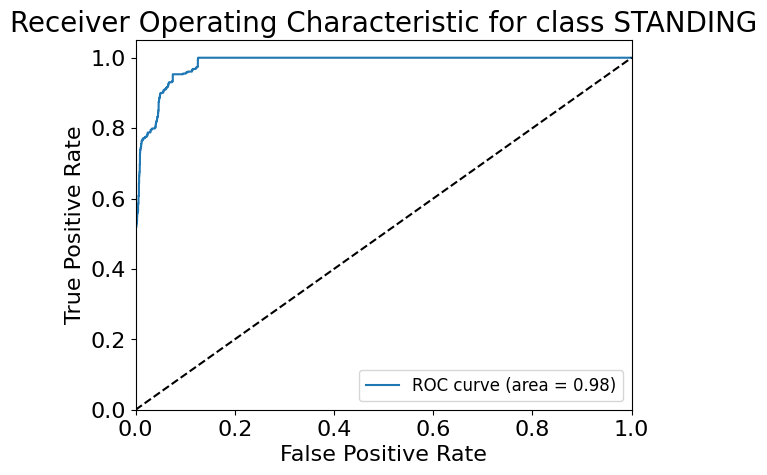

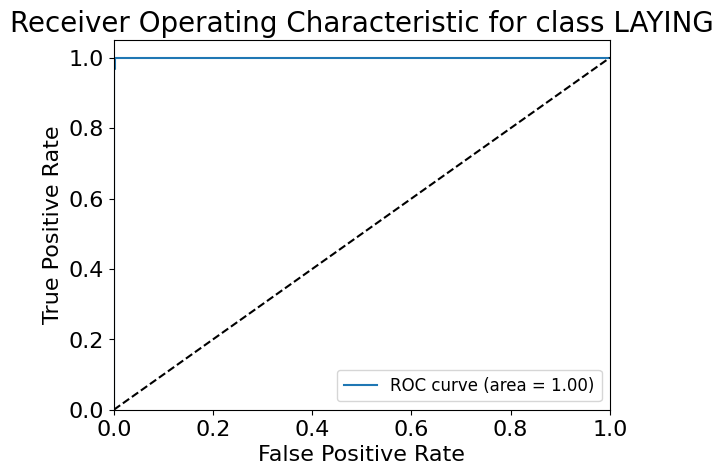

In [80]:
plot_roc_curve(test_labels, cnn_gru_predictions, n_classes, labels)

# CNN+LSTM

## Creating the Model

In [81]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, LSTM, Dropout

# Define the model
cnn_model = Sequential([
    # Convolutional layer that will receive the time series as input
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_time_steps, n_features)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    # LSTM layer to interpret the features extracted by the CNN
    LSTM(64),
    # Fully connected layer to make the final decision
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(n_classes, activation='softmax')
])

# Compile the model
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 126, 64)           1792      
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 63, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_16 (Conv1D)          (None, 61, 128)           24704     
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 30, 128)          0         
 g1D)                                                            
                                                                 
 lstm_4 (LSTM)               (None, 64)                49408     
                                                                 
 dense_16 (Dense)            (None, 64)               

## Testing the Model

In [82]:
# Train the model
history = cnn_model.fit(train_data, train_labels, epochs=10, batch_size=32, validation_split=0.2)

# Predictions with test data
cnn_predictions = cnn_model.predict(test_data)

Epoch 1/10
184/184 [==============================] - 15s 64ms/step - loss: 0.7542 - accuracy: 0.6939 - val_loss: 0.6612 - val_accuracy: 0.7505
Epoch 2/10
184/184 [==============================] - 9s 48ms/step - loss: 0.3335 - accuracy: 0.8852 - val_loss: 0.4453 - val_accuracy: 0.8919
Epoch 3/10
184/184 [==============================] - 11s 58ms/step - loss: 0.2201 - accuracy: 0.9237 - val_loss: 0.4269 - val_accuracy: 0.8946
Epoch 4/10
184/184 [==============================] - 11s 61ms/step - loss: 0.1724 - accuracy: 0.9407 - val_loss: 0.5031 - val_accuracy: 0.9055
Epoch 5/10
184/184 [==============================] - 12s 64ms/step - loss: 0.1422 - accuracy: 0.9507 - val_loss: 0.4852 - val_accuracy: 0.9103
Epoch 6/10
184/184 [==============================] - 12s 64ms/step - loss: 0.1273 - accuracy: 0.9520 - val_loss: 0.5896 - val_accuracy: 0.8994
Epoch 7/10
184/184 [==============================] - 10s 57ms/step - loss: 0.1116 - accuracy: 0.9560 - val_loss: 0.5265 - val_accuracy: 

Accuracy: 0.91


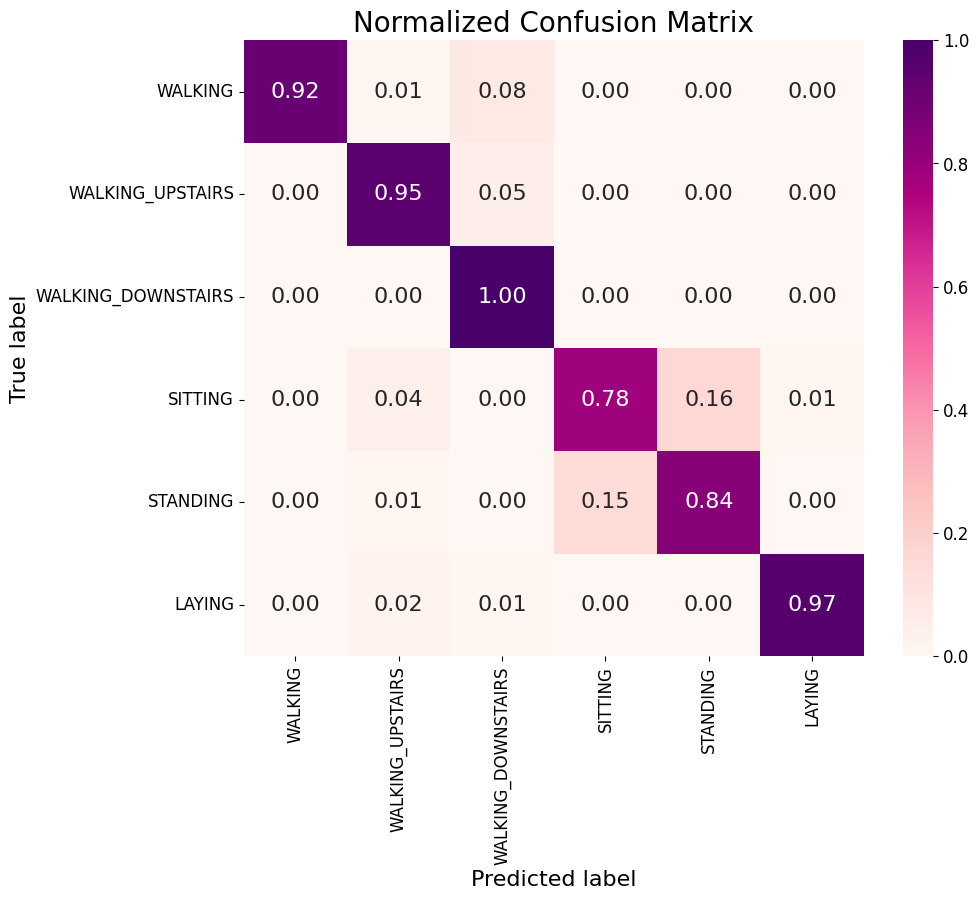

Precision per class: 1.00, 0.91, 0.86, 0.83, 0.85, 0.99
Recall per class: 0.92, 0.95, 1.00, 0.78, 0.84, 0.97
F1 Score per class: 0.95, 0.93, 0.93, 0.81, 0.84, 0.98
Macro Precision: 0.91
Macro Recall: 0.91
Macro F1 Score: 0.91
Mean cross-entropy loss: 0.49


In [83]:
print_metrics(original_classes, cnn_predictions, labels)

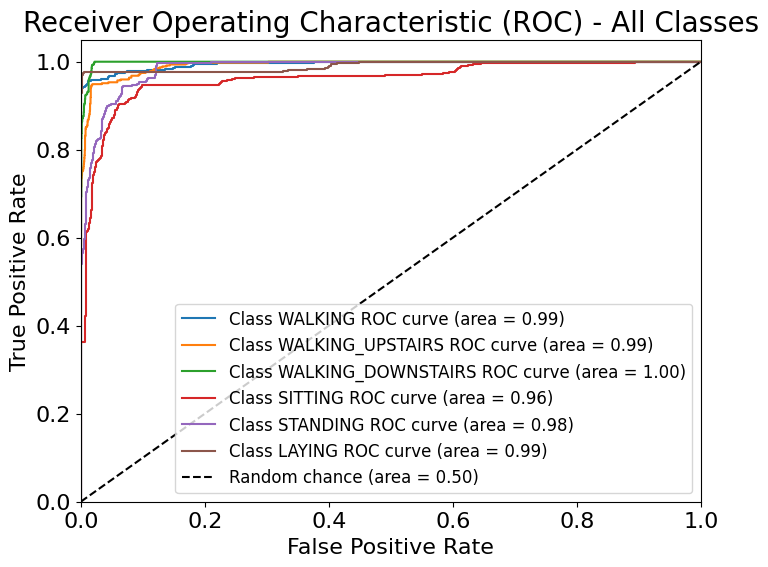

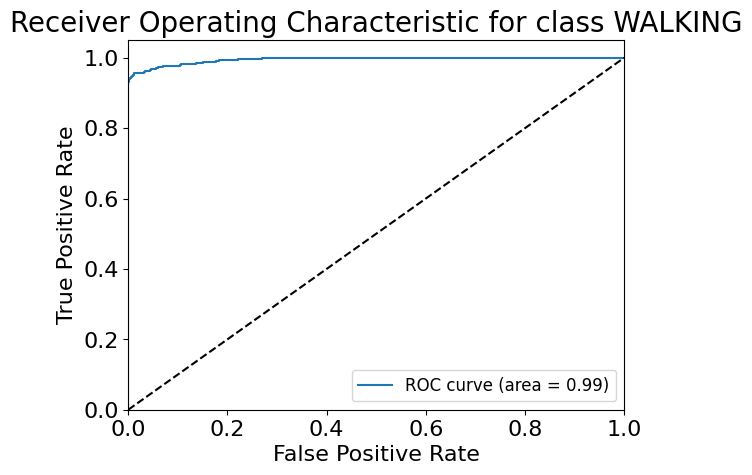

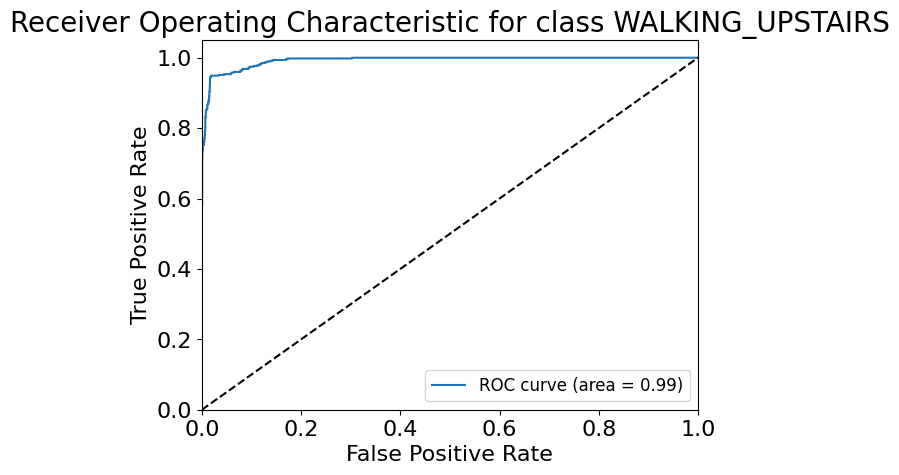

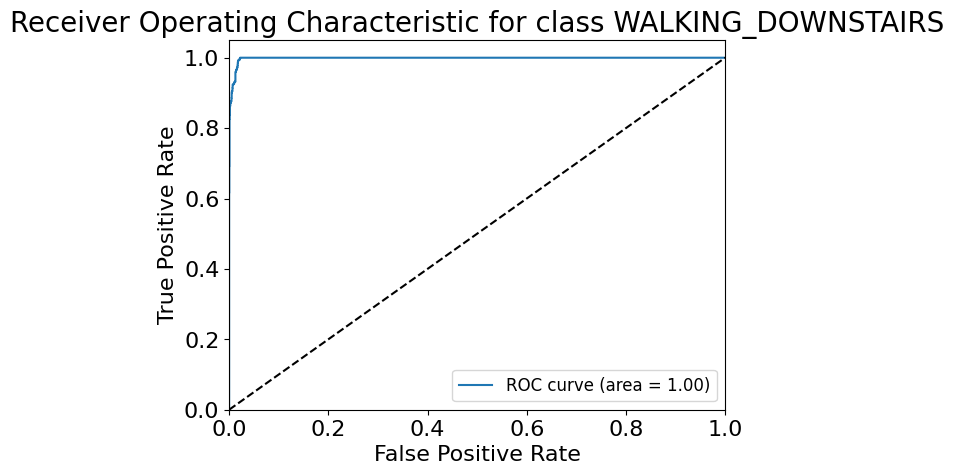

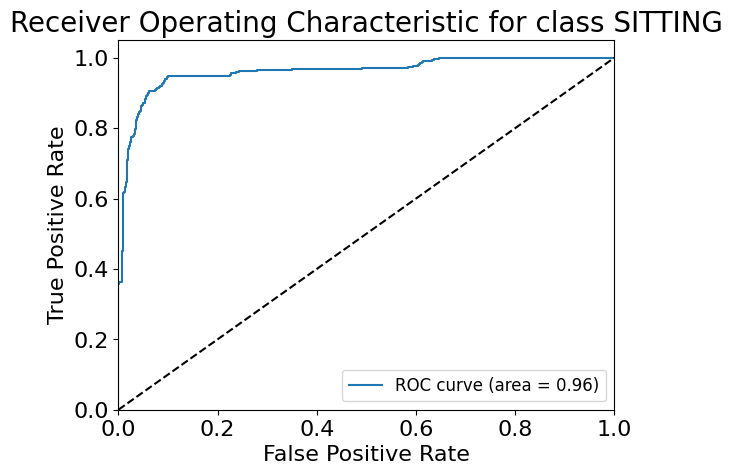

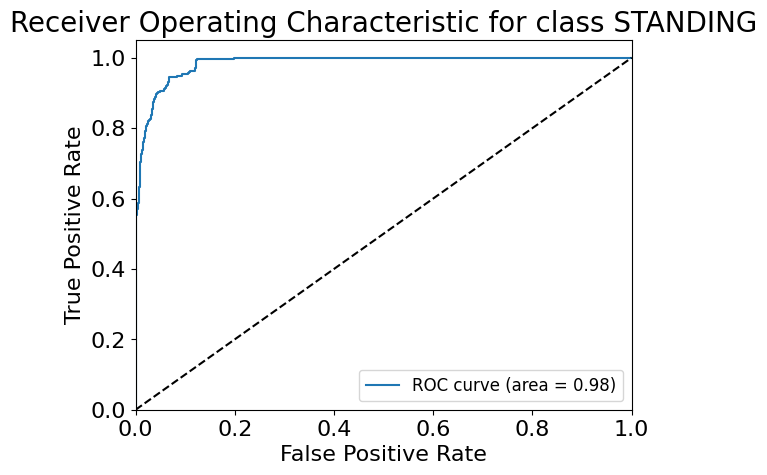

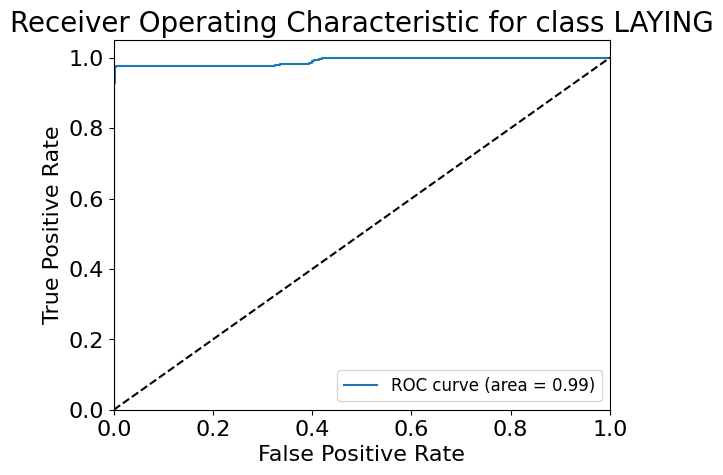

In [84]:
plot_roc_curve(test_labels, cnn_predictions, n_classes, labels)